In [41]:
import tweepy
from tweepy import OAuthHandler
from tweepy import Cursor
from unidecode import unidecode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
from sklearn import mixture as mix
from collections import Counter
import sklearn
import scipy
import nltk
import string

# Political Tweet Data Analysis Project
Danniel Yang, Yuan Gao

## Components of this Tutorial:
1. Introduction
2. Data Scraping
3. Distribution Modeling
4. Number of Retweets VS Number of Likes
4. Content-based Classification
5. Conclusion and Other Resources
6. Reference
7. Appendix

## 1. Introduction
Twitter is a unique social network platform for disseminate information. It encourages users to share their ideas or emotions via short messages and allows those messages to spread out very quickly by being "liked" or "retweeted". Therefore, Twitter holds a plethora of information. Over the years, people have used the platform to conduct many interesting research topics. One of the questions that people are very curious about is why some tweets are much more popular than others. This is important for individuals, companies and media that want to effectively promote themselves online and gain public attention. 

In this project, our main focus is on tweets posted by politics-related twitter accounts. This result will be useful since it will give politicians ideas on how they could market and promote their ideas and opinions. We define popularity of a tweet by number of retweets. Our approach consists of two parts -- the first one is distribution modeling, and the second one is classification. Therefore, we first try to model the distribution on number of retweets, and see if we can get any insights on the pattern of the data. Then we filter our data based on the observations, and try to use classification algorithms to determine the factors behind popularity of tweets.

## 2. Scraping of Twitter Data

We believe that both content and context of a tweet are crucial in determining its popularity. Context refers to information other than content, such as the author, or number of 'likes' the tweet receives. Therefore, we scrape all the related information regarding a tweet. 

We use Tweepy together with Twitter API to scrape tweets. We use the top-50 US politics twitter accounts list gathered by Guadian as our source. We also added two other features, number of happy words and sad words, to help with sentiment analysis of tweets content later on. 

In [61]:
users = ["top-50-us-politics"]
api = get_api()
df = get_tweet_info(api, users, 60)

In [23]:
df.to_csv("politicians_tweet_data.csv")

## 3. Modelling the Distribution
In this modeling task, we extracts a dataset of 10454 tweets for distribution modeling.

In [64]:
df = pd.read_csv("politicians_tweet_data.csv", index_col = 0)

In [3]:
df2 = pd.read_csv("politicians_tweet_data2.csv", index_col = 0)

### 3.1 Distribution Visualization using Histogram

We plot histograms of the natural logarithms of the number of retweets. We chose to take the log of the data first before plotting them since we found the retweets span a very large range, from none to tens of thousands, or even millions. We used a trick that we think should preserve the distribution, but makes plotting easier, which is that we add one to the retweets before plotting them. If the number of bins is high enough, adding a constant to data will still give you the correct sense of what kind of distribution the data comes from, maybe it just makes it so that you can't directly model it. Since a lot of the retweet counts are zero, taking the log would be undefined, so we add one to make them come out to be zero. 

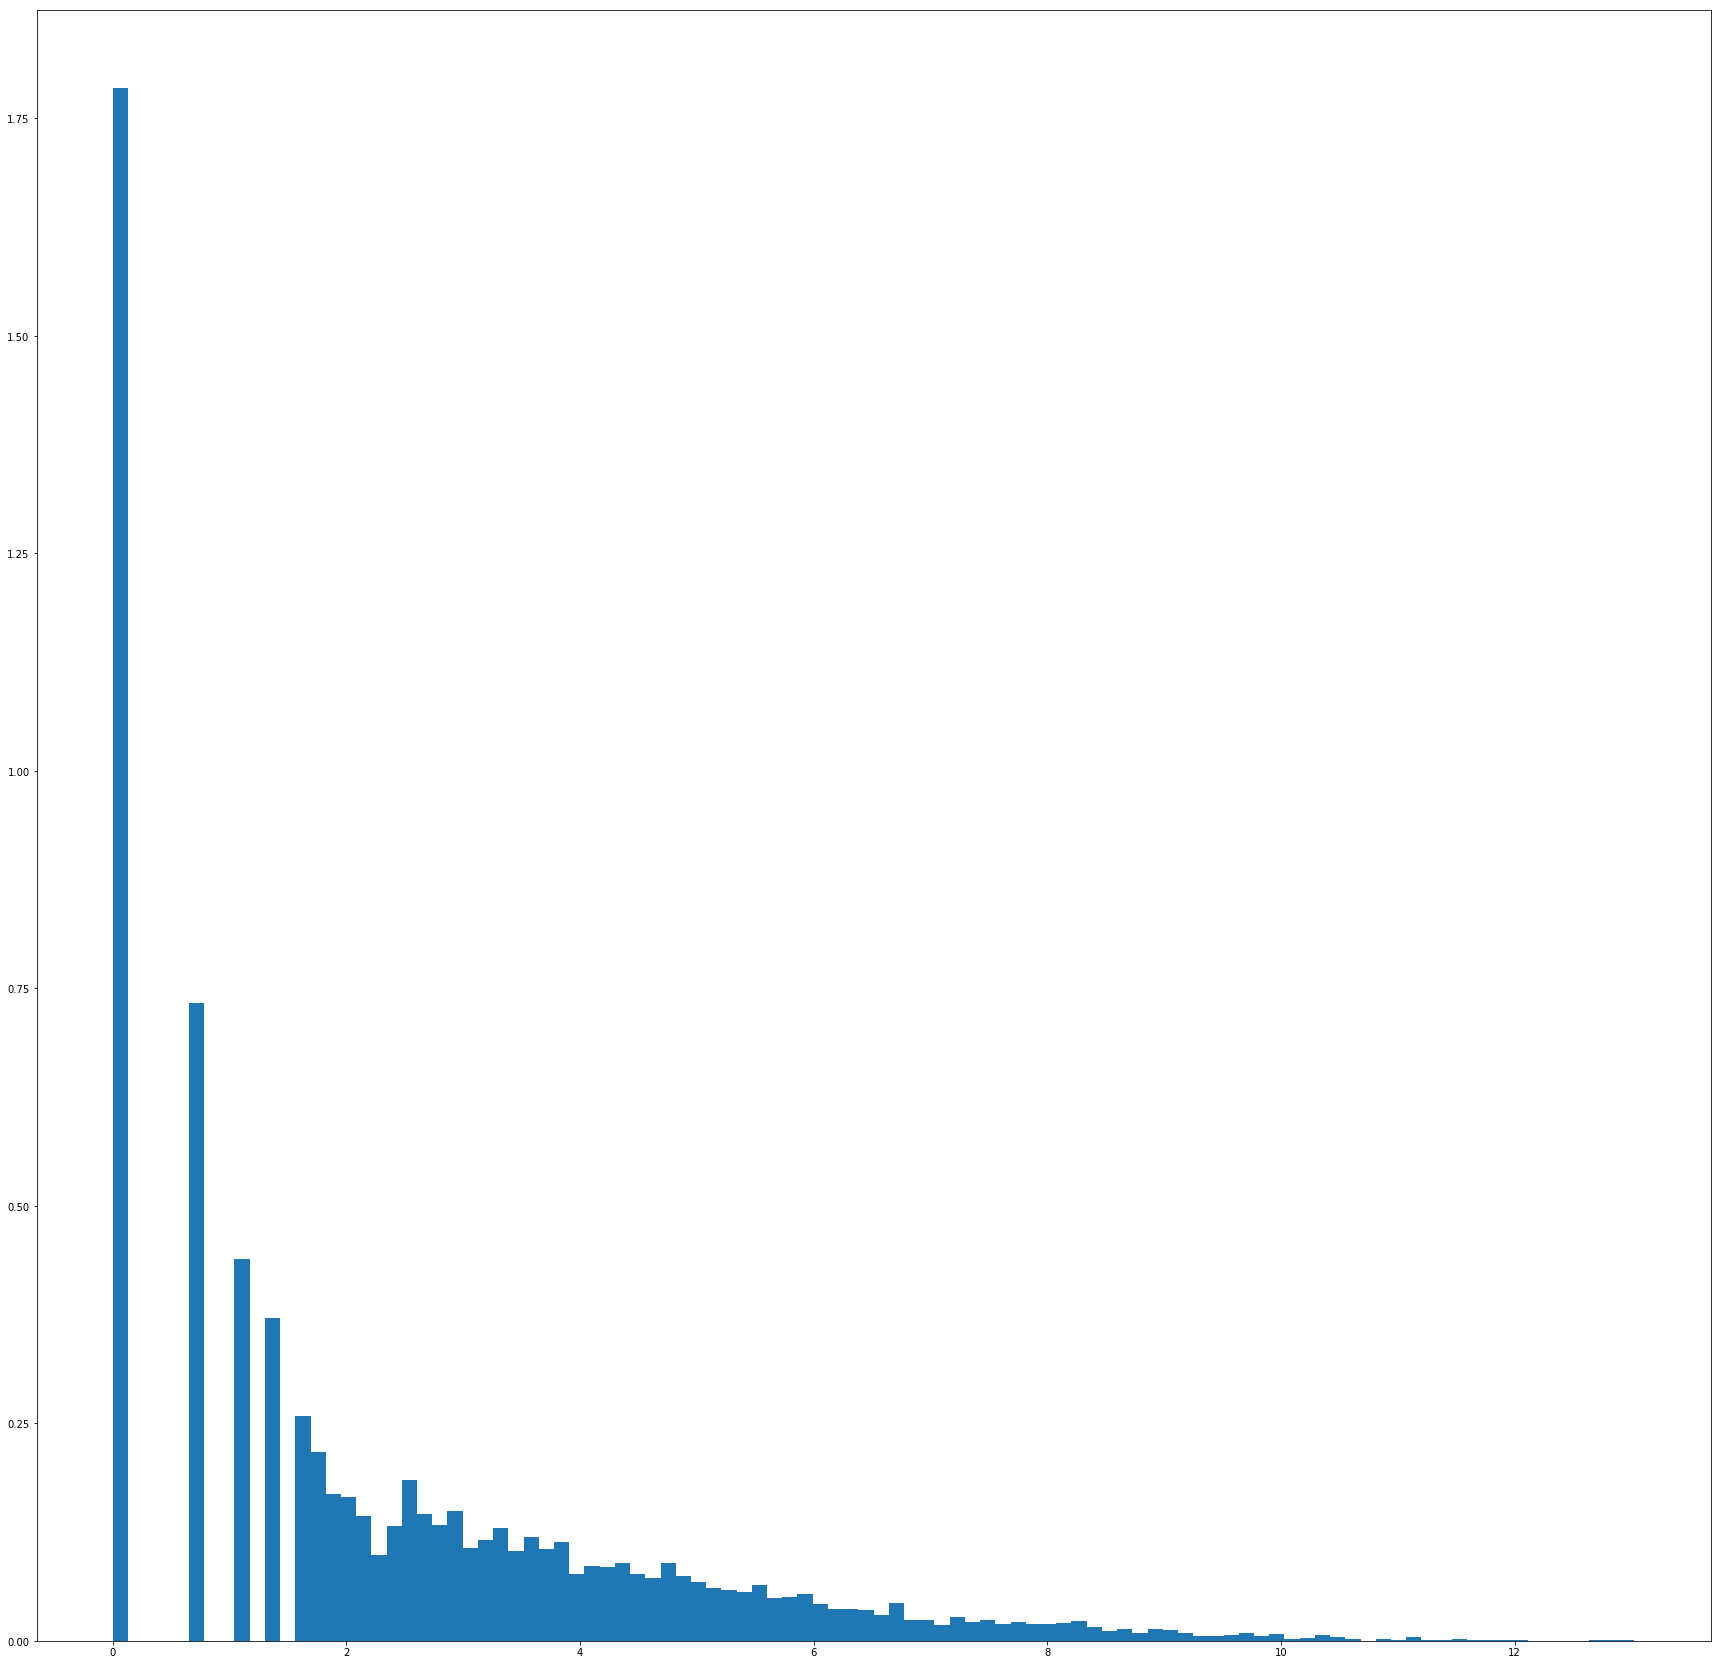

In [16]:
matplotlib.rcParams["figure.figsize"] = [30, 30]
#natural log of the retweets, +1 to prevent log(0) problem
log_retweets = np.log(df["retweets"] + 1)
plt.hist(log_retweets, bins = 100, density = True)
plt.show()

The distribution is clearly exponential-esque. It is not quite exponential since the starting frequency is way too high, and then after decreasing pretty rapidly it also slows down very quickly, so that it has heavy tails. It needs a more complicated distribution function to describe. 

### 3.2 Distribution Modeling
#### Gaussian Mixture Model 

Here we try to fit a Gaussian Mixture Model to the data. As you can see, it works pretty poorly. We think it would be the same even if we increase the number fo Gaussians. We believe it is because the data is just not Gaussian, even if a mixture of Gaussians can fit any data, and that the first part is too high so that it needs a very narrow and tall Gaussian there which means it would also drop down really fast. We believe that our data is exponential in nature, and if a mixture of Gaussians fit the data well because log retweets is inherently discrete and so some x values have no probability and some have very high.

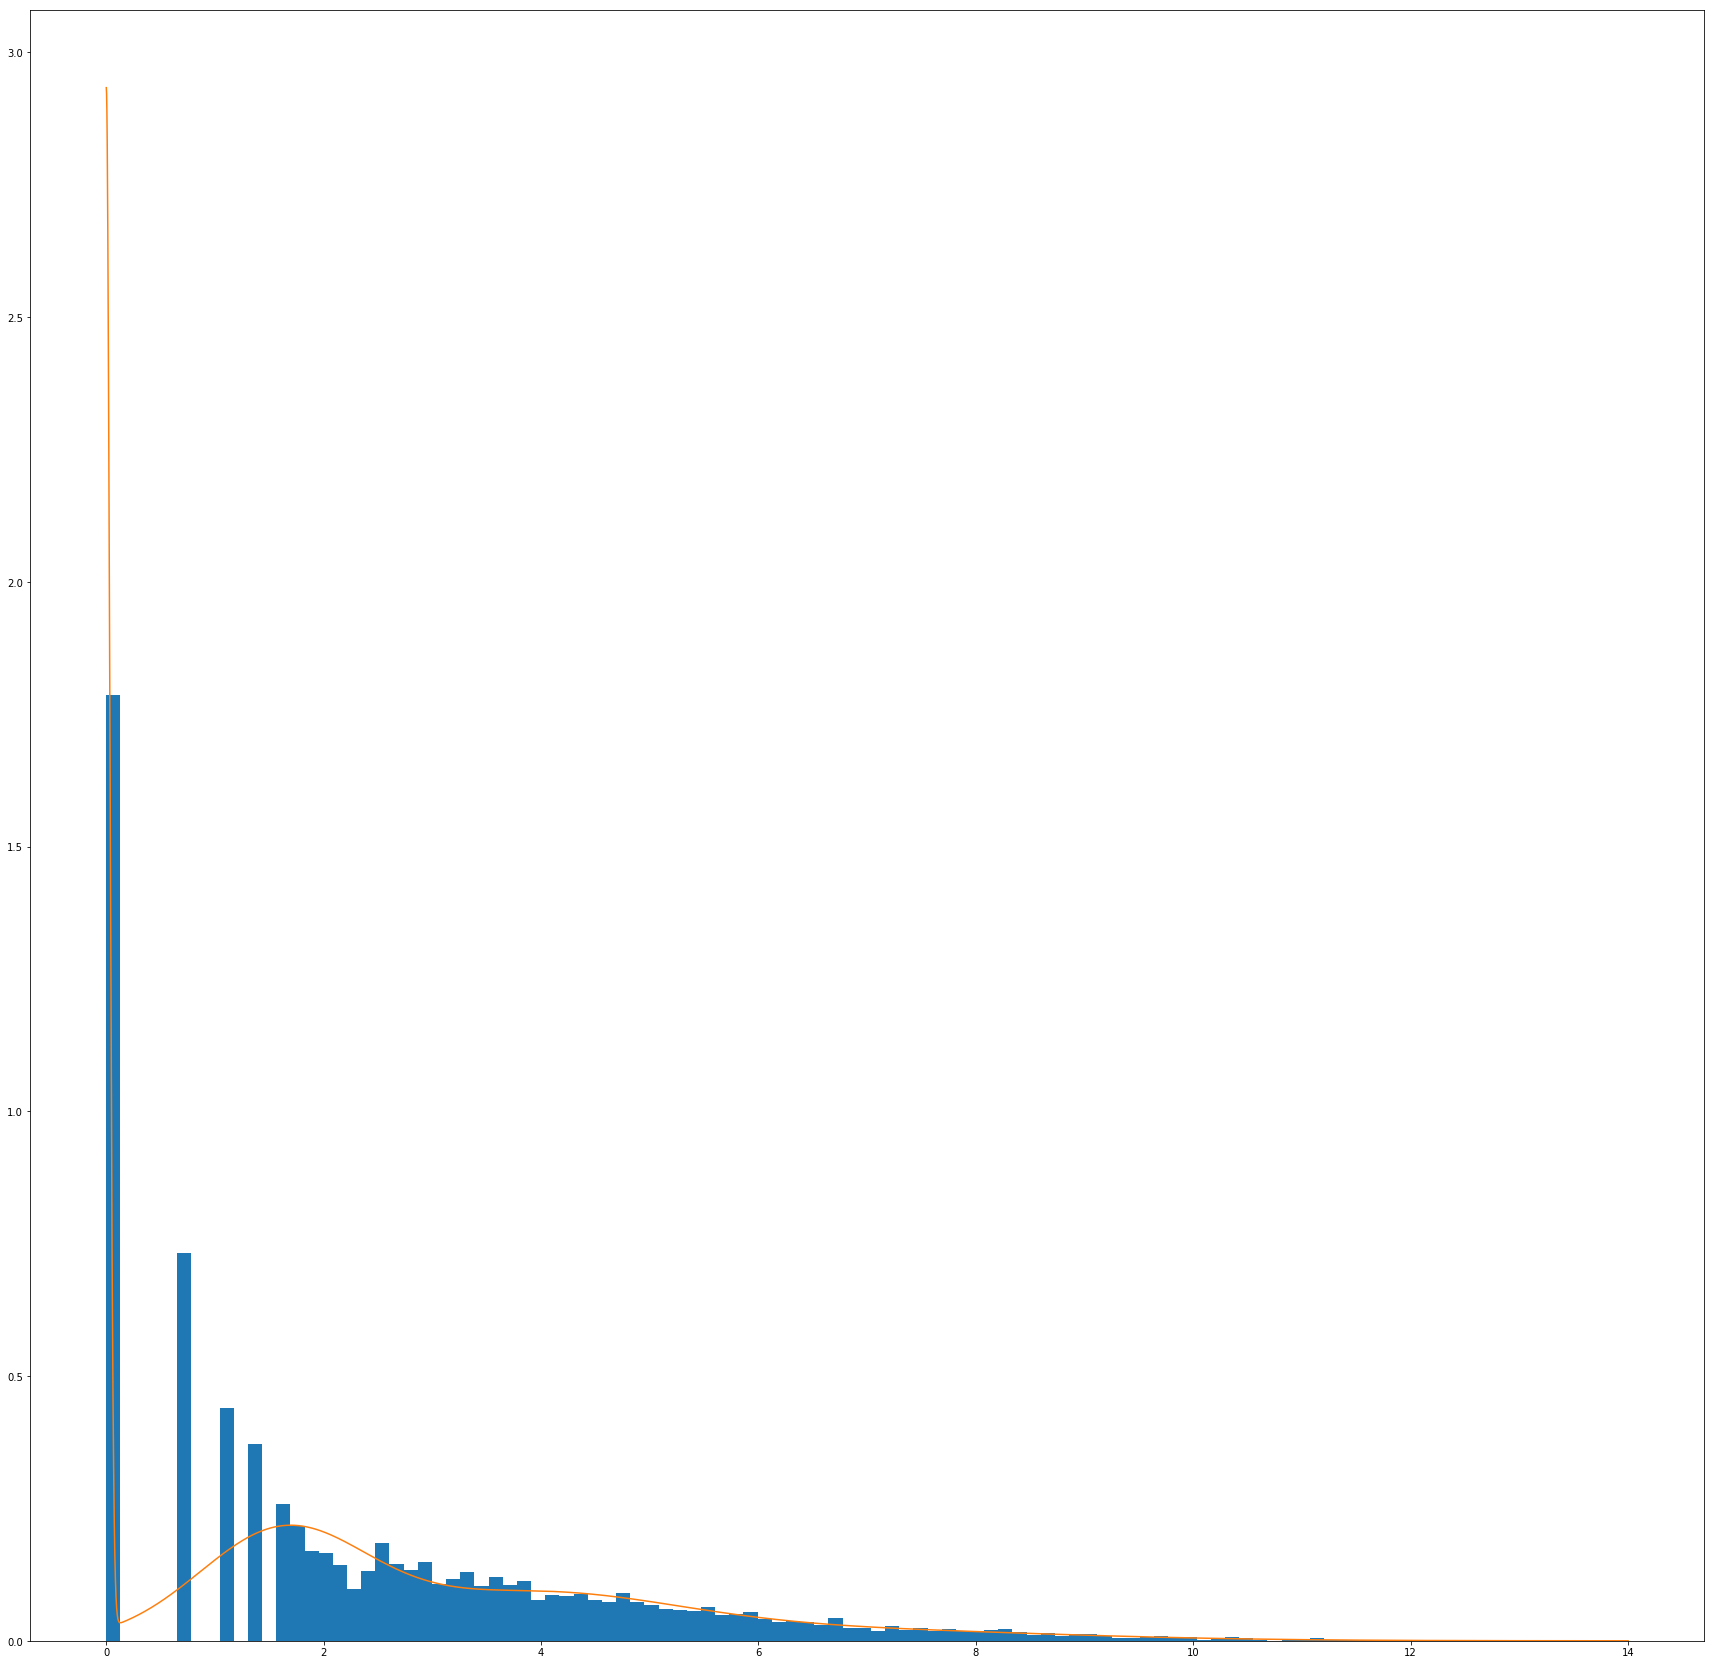

In [9]:
fig1, ax1 = plt.subplots(nrows = 1, ncols = 1)
ax1.hist(log_retweets, bins = 100, density = True)
gmm = mix.GMM(n_components = 4, covariance_type = 'full')
gmm = gmm.fit(np.expand_dims(log_retweets, 1))
gmm_x = np.linspace(0, 14, 5000)
gmm_y = np.exp(gmm.score(gmm_x.reshape(-1, 1)))
ax1.plot(gmm_x, gmm_y)

#### Customized Distribution
As we can observe from the histogram, the counts of the first four bins stand alone on their own, while the other bins seem to follow a exponential distribution. 

In [32]:
n, bins, patches = ax.hist(log_retweets, bins = 100, density = True)

We calculated the bin edges and found out that each of the four stand-alone bins in the histogram above denotes the count of tweets that have 0 to 3 retweets. The following four lines of code are trying to determine what proportion of the entire sample space is each retweet count from 0 to 3.

In [42]:
print(len(log_retweets[log_retweets == 0]) / len(log_retweets))

0.2325648139290156


In [44]:
print((len(log_retweets[log_retweets <= 0.7]) - len(log_retweets[log_retweets <= 0.6]))/ len(log_retweets))

0.09547498325839472


In [45]:
print((len(log_retweets[log_retweets <= 1.1]) - len(log_retweets[log_retweets <= 1]))/ len(log_retweets))

0.05720845690232469


In [46]:
print((len(log_retweets[log_retweets <= 1.4]) - len(log_retweets[log_retweets <= 1.3]))/ len(log_retweets))

0.04831148952453841


In [48]:
probbs = [0.2325648139290156, 0.09547498325839472, 0.05720845690232469, 0.04831148952453841]

Therefore, we comes up with this customized distribution. The distribution is: Flip a biased coin with the probabilities being equal to the proportion of samples that have retweets from 0 to 3. If it lands on heads, then randomly choose one of 0 to 3 based on their respective proportions. This is trying to approximate the part of the sample distribution that is way higher than an exponential distribution by treating them separately. If the coin lands on tails, then sample from an exponential distribution that is fit to the rest of the log retweets. Our goal is to see whether after plotting the histogram of the sampled data, it looks like the histogram of the original sample.

In [62]:
def sample_from_mixed_dist(choices, probs, lam, scale, min_minus, rangee, prob):
    if np.random.choice(a = [0, 1], p = [prob, 1 - prob]) < 1:
        return np.random.choice(a = choices, p = probs)
    else:
        #the samples are from an actual distribution, but we need the retweet
        #counts to be bigger than  and stretched back, so apply the scaling
        #backwards
        return np.random.exponential(scale = 1 / lam) * rangee / scale + min_minus


In [ ]:
#Code for computing the MLE and plotting an exponential distribution
import math
def exp_mle(retw):
    return sum(retw) / len(retw)
def plot_exp(lam, x, ax):
    ax.plot(x, [lam * math.exp(-lam * t) for t in x])
    plt.show()

In [ ]:
#get only the retweets that are bigger than 4, and scale them so that
#they can be better fit by an exponential distribution
log_retweets5 = log_retweets[log_retweets > 1.4]
min_log2 = min(log_retweets5)
max_log2 = max(log_retweets5)
log_retweets5 = (log_retweets5 - min_log2) * 4.5 / (max_log2 - min_log2)

In [61]:
mle_lam = exp_mle(log_retweets5)
choices = [0, np.log(2), np.log(3), np.log(4)]
prob_sum = sum(probbs)
norm_probs = [i / prob_sum for i in probbs]
samples = [sample_from_mixed_dist(choices, norm_probs, mle_lam, 4.5, min_log2, (max_log2 - min_log2), prob_sum) for i in range(len(log_retweets2))]

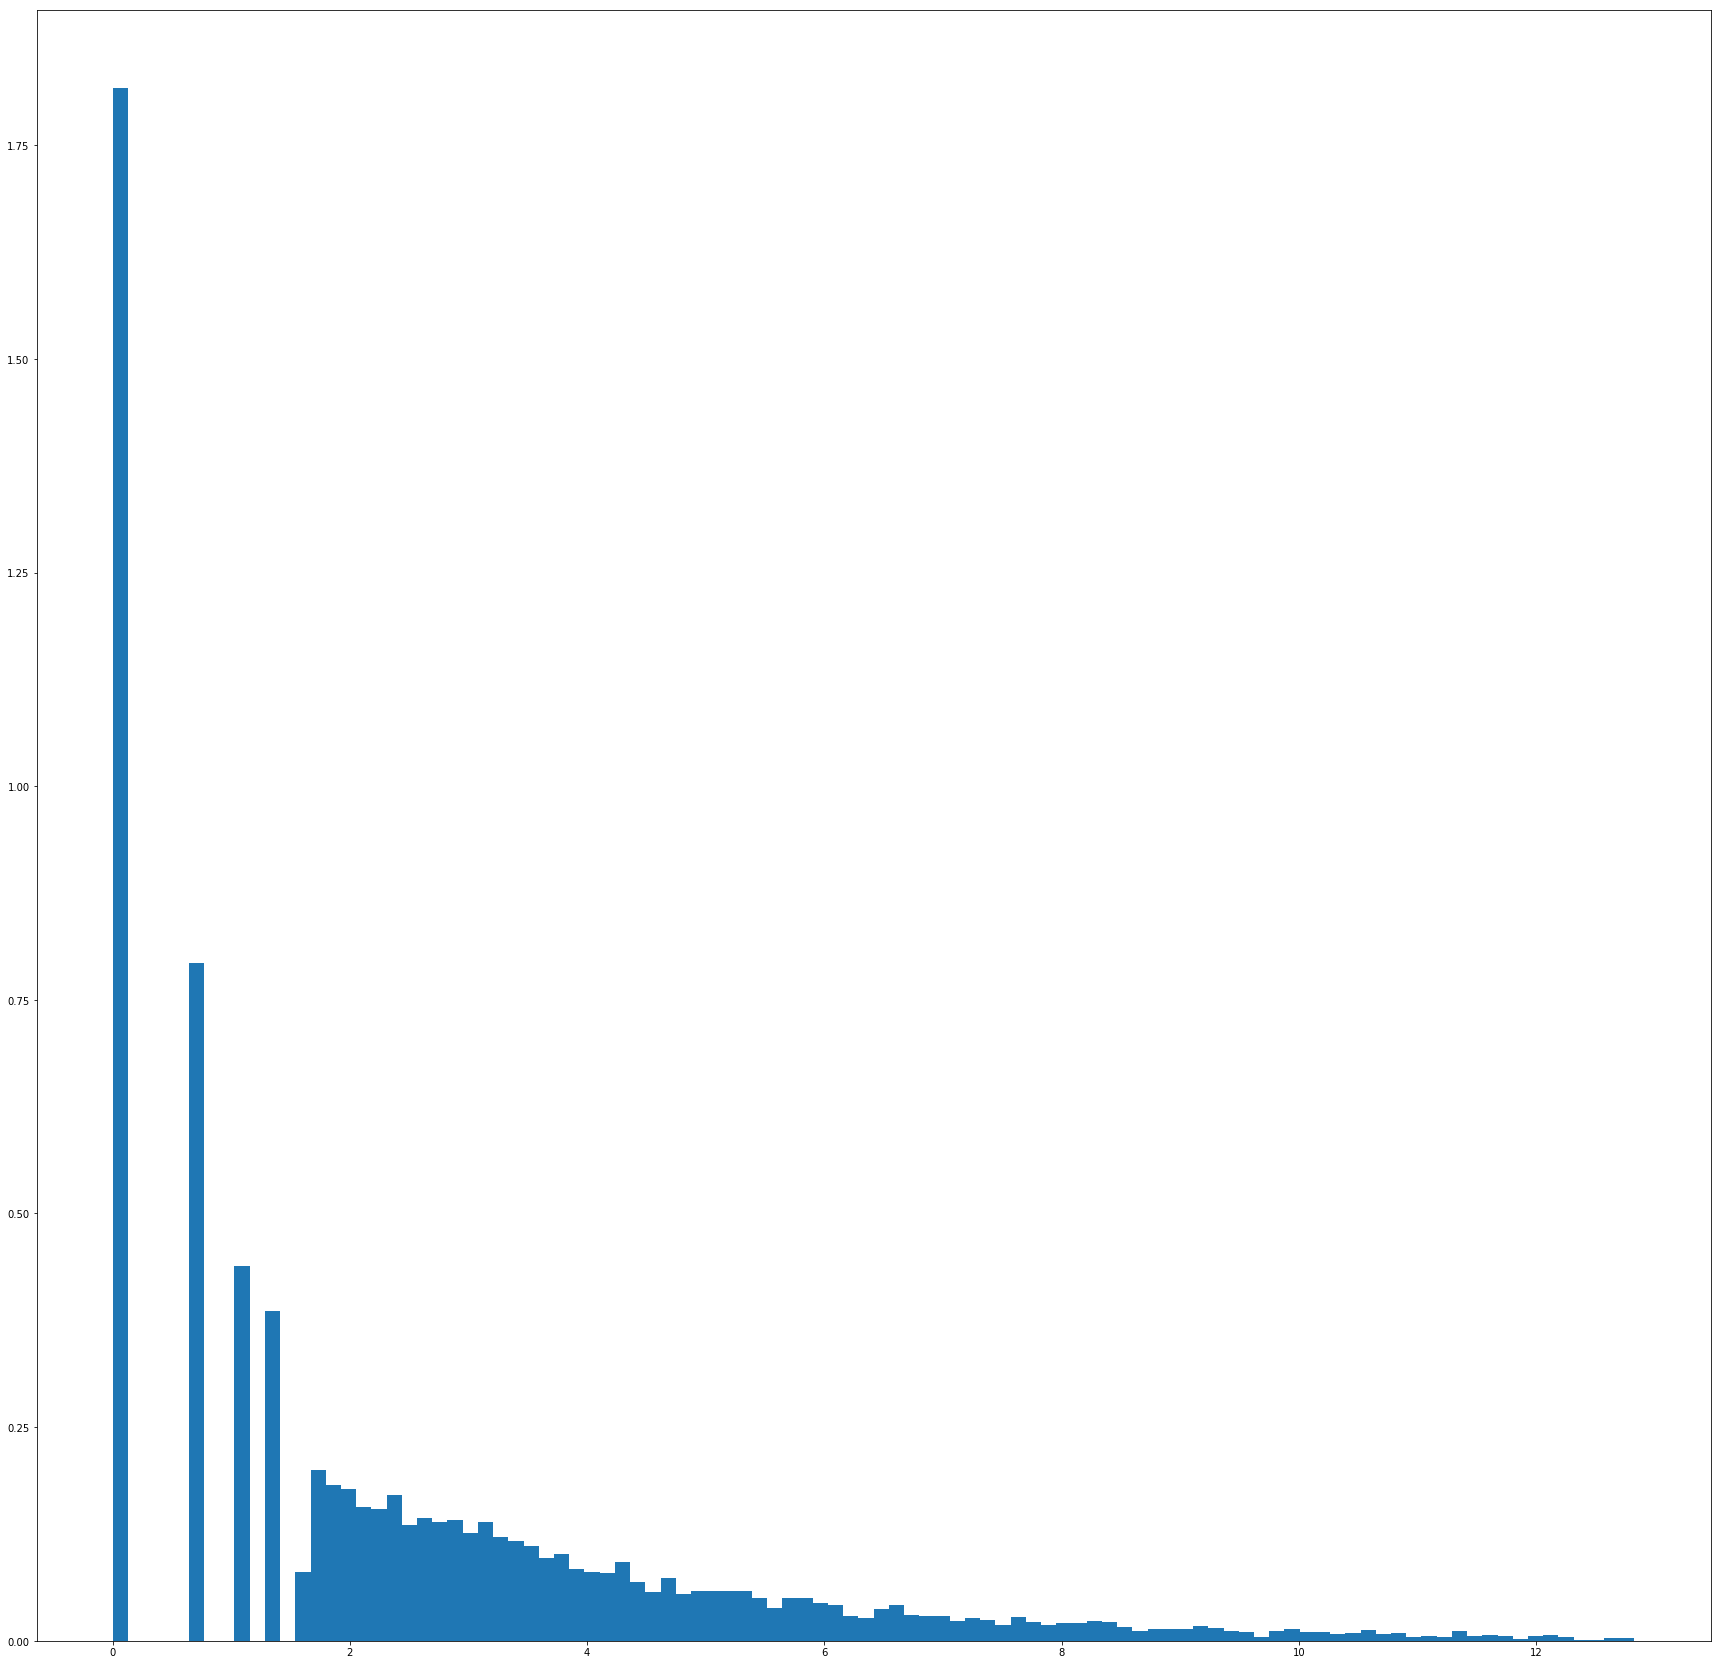

In [72]:
plt.hist(samples, bins = binss, density = True)
plt.show()

By just comparing the histogram, we can see that our customized distribution looks quite similar to the real distribution. We evaluate the samples by counting the number of tweets that falls into wrong bins in our distribution. We get this by summing the differences of the counts of each bin and divide by 2 in the end to avoid double counting the errors.

In [74]:
def diff_prob(samples, x):
    n, bins, patches = plt.hist(samples, bins = binss)
    n2, bins2, patches2 = plt.hist(x, bins = binss)
    print(sum(abs(n2 - n)) / 2)
diff_prob(samples, log_retweets2)

945.0


We get 945 out of 10454 in the wrong bin. We think the modeling is rather effective.

## 4. Number of Retweets VS Number of Likes
### 4.1 Distribution of Number of Likes
By observing the data, we found out that the distribution of number of likes (#Likes) and number of retweets (#Retweets) look quite similar. They both have a lot of zero entries. As for non-zero entries, some are as large as a few thousands. Therefore, we also did a brief analysis on distribution of #Likes.

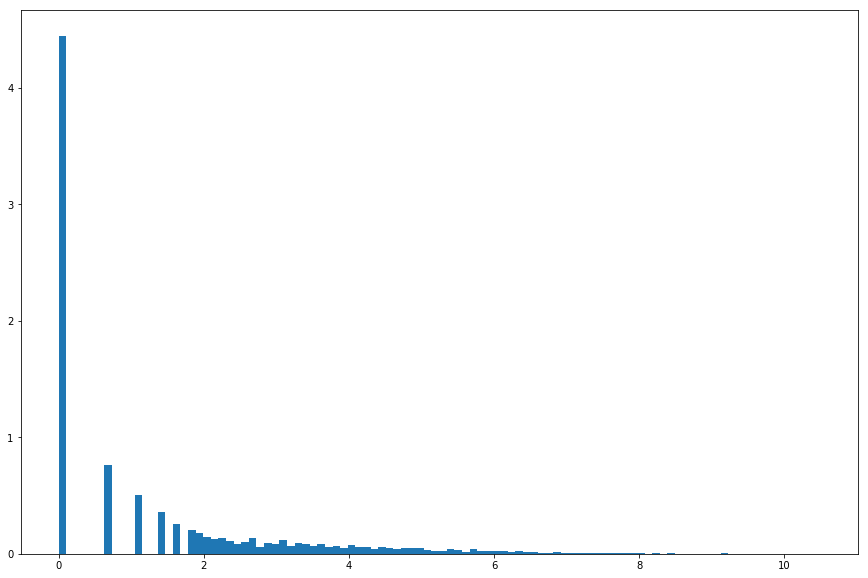

In [65]:
favor = df['favourites']
#log of favor + 1
log_favor = np.log(favor + 1.0)
matplotlib.rcParams["figure.figsize"] = [15, 10]
h = plt.hist(log_favor, density=True,bins=100)
plt.show()

By comparing the graph above with the distribution of #retweet, we can realize that they both have a similar exponential-esque distribution, but #Likes's first bin is even larger. This implies that predominant amount of retweets receives minimal number of favorites. 
### 4.2 Correlation between #Likes and #Retweets
Given the similarity between these two features, is there any possible correlations between the two. If so, is it possible to predict one using another?

We first use Pearson's Correlation Coefficient to describe the correlation between the two features, and we also plot a scatter plot that shows the #Retweets and #Likes of each tweet. The result is as follows: 

Pearson Correlation:  0.07575180033362851


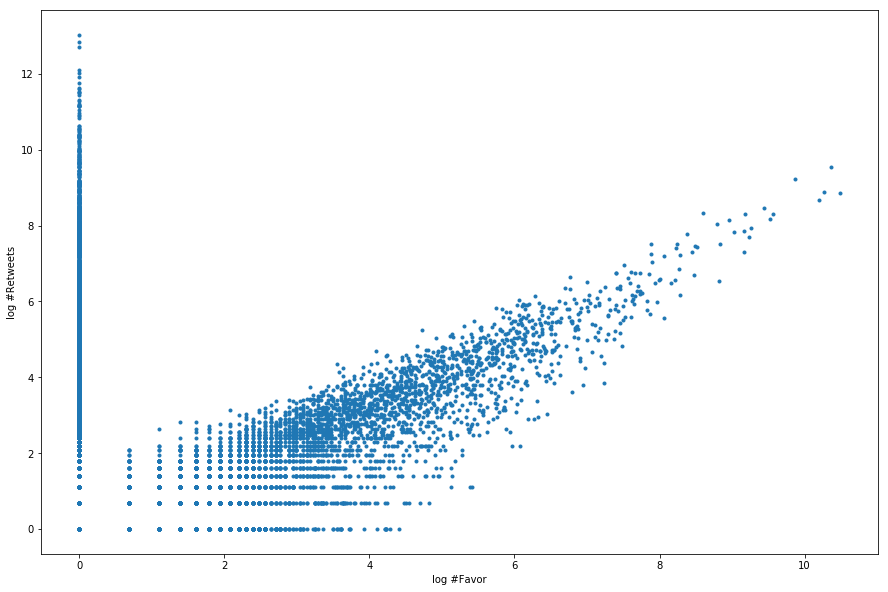

In [38]:
from scipy.stats import pearsonr
#Pearson correlation coefficient
print('Pearson Correlation: ', pearsonr(log_retweets, log_favor)[0])

#Plot scatter between the two log functions
fig2, ax2 = plt.subplots()
ax2.scatter(log_favor, log_retweets, c='C0', marker = '.')
ax2.set_xlabel('log #Favor')
ax2.set_ylabel('log #Retweets')
plt.show()
fig2.savefig('scatter.png')

From the graph above, we could see that there are distinct two separate clusters -- one with 0 or very few #Favor but arbitrary number of #Retweets, and as log of #Favor increases to 5, there starts to have some correlation between the two features. However, the Pearson Correlation coefficient is 0.075, implying nearly no correlation. 

We also did a simple linear regression between the two features:

In [36]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

df_sampled = df.sample(frac=1).reset_index(drop=True)
train = len(df_sampled)*8//10
df_train = df[:train]
df_test = df[train:]
favor_tr = np.array(df_train['favourites']).reshape(-1,1)
favor_te = np.array(df_test['favourites']).reshape(-1,1)
retweet_tr = np.array(df_train['retweets'])
retweet_te = np.array(df_test['retweets'])

lr = linear_model.LinearRegression()
log_tr_f = np.log(favor_tr+1)
log_tr_r = np.log(retweet_tr+1)
lr.fit(log_tr_f, log_tr_r)
log_te_r = np.log(retweet_te+1)
pred_log_r = lr.predict(np.log(favor_te+1))

print('Coefficients: \n', lr.coef_)
print("Mean squared error: %.2f" % mean_squared_error(pred_log_r, log_te_r))


Coefficients: 
 [-0.01861761]
Mean squared error: 9.22


As we can see, the coefficient is close to 0, and the mean squared error is as high as 9.22. This shows that using #Likes to predict #Retweet might not be a useful approach. 

## 5. Content-based Classification

From the distribution analyses we did on both #Retweet and #Favor, we discovered that there seems to be two distinct clusters of data, based on whether or not a tweet has retweets. 
Therefore, we thought it might be a good idea to categorize the data according to this characteristic, and try to do some classification. 

Since the seemingly most relavant contextual feature -- number of favorites, is not very useful, we try to approach from a different direction. Our assumption is that between a tweet that gets thousands of retweets, and a tweet that has zero retweet, there must be some significant content differences. Therefore, for the following classification tasks, we alternatively focus on using tweet content to predict its popularity.

### 5.1 Attempted Classification with Sentiment Words

On most social network platforms, sentiment words always have direct impact on how controversial a post is. Therefore, on our first step of content-based classification, we try to extract sentiment words from tweets, and explore their importance in deciding whether a tweet will go viral. 

In [39]:
df["total_words"] = df["happy_words"] + df["sad_words"]
df["has_retweet"] = df["retweets"].map(lambda x: min(1, x))
print(df.groupby(["total_words", "has_retweet"]).size())
print(df.groupby(["happy_words", "has_retweet"]).size())
print(df.groupby(["sad_words", "has_retweet"]).size())

total_words  has_retweet
0            0              1527
             1              4303
1            0               669
             1              2501
2            0               182
             1               940
3            0                48
             1               238
4            0                 5
             1                31
5            1                 9
dtype: int64
happy_words  has_retweet
0            0              1841
             1              5762
1            0               491
             1              1802
2            0                84
             1               393
3            0                10
             1                61
4            0                 5
             1                 2
5            1                 2
dtype: int64
sad_words  has_retweet
0          0              2013
           1              6026
1          0               354
           1              1585
2          0                58
           1        

As you can see from the print out, there is no correlation at all between the number of sentiment words and whether a tweet gets retweeted or not. It seems very uniform: a tweet can be retweeted regardless of the number of sentiment words.

We think that this classification task may not be a good idea because it assigns a special meaning to the boundary of 0 retweet and 1 retweet, and that has to intuitively be a cutoff point for a classifier to work. But in fact, it's not. The difference between 1 retweet and 1000 retweets should be more significant than that of 0 and 1 retweet instead. 

Moreover, we infer that number of sentiment words might not be a good indicator of the content of tweets. This is reasonable since sentiment words are rather limited, and sometimes social network vocabularies and expressions might be quite different from the traditional expressions of emotions and opinions.

We also scraped a larger dataset from Twitter with 65535 entries. We will use this larger dataset for the following analyses.

In [69]:
df3 = pd.read_csv("politician_data_fullset.csv", index_col = 0, low_memory = False)
df3.drop(df3.columns[list(range(14, len(df3.columns)))], axis = 1, inplace=True)

In [ ]:
df3["retweets"] = pd.to_numeric(df3["retweets"], errors = "coerce")
df3.dropna(inplace = True)

In [29]:
df3.sort_values(by=["retweets"], ascending=False, inplace=True)
print(df3.head())

       direct_reply    year  month_sin  month_cos  time_since_posted  \
53002           0.0  2017.0  -0.866025  -0.500000       2.258562e+07   
19124           0.0  2017.0  -0.500000   0.866025       1.397182e+07   
18945           0.0  2018.0   0.866025   0.500000       5.861774e+06   
34155           0.0  2018.0   0.866025   0.500000       6.443694e+06   
34324           0.0  2018.0   0.500000   0.866025       9.136650e+06   

       is_quote  hashtags  user_mentions  medias  urls  english  favourites  \
53002       0.0       0.0            1.0     0.0   0.0      1.0         0.0   
19124       0.0       0.0            1.0     0.0   0.0      1.0         0.0   
18945       0.0       0.0            1.0     0.0   0.0      1.0         0.0   
34155       0.0       0.0            1.0     0.0   0.0      1.0         0.0   
34324       0.0       0.0            1.0     0.0   0.0      1.0         0.0   

                                             tweet_words   retweets  
53002  RT @BarackObama

We want to see whether we can guess if a retweet is from the first or last tenth percentile, and if we can do it a classifier possibly can too. So we took the code from lecture and modified it a little bit to play our game

In [37]:
def ranking_game2():
    it1 = np.random.randint(len(df3)//10)
    it2 = np.random.randint(len(df3)//10) + 9*len(df3)//10
    if np.random.rand() < 0.5:
        it1,it2 = (it2,it1)
    
    print(df3.iloc[it1]["tweet_words"])
    print("-------")
    print(df3.iloc[it2]["tweet_words"])
    print("-------")
    
    guess = int(input("Which tweet has more retweets (1/2)?"))
    
    print("True Rating: {} / {}".format(df3.iloc[it1]["retweets"], df3.iloc[it2]["retweets"]))
    correct = ((guess == 1) and (it1 < it2)) or ((guess == 2) and (it1 > it2))
    print("{}".format("Correct!" if correct else "Incorrect!"))

In [47]:
ranking_game2()

I had a dream last night that someone cut all my hair off while I was sleeping 😱 What does this mean!
-------
There are 118 House Republicans in seats that went for Trump by less than this district. Democrats need to win 24 s… https://t.co/6sZU4758x6
-------
Which tweet has more retweets (1/2)?2
True Rating: 0.0 / 904.0
Correct!


It seems that we can do pretty well on these ranking games. Therefore, it might be more meaningful to split data in this way and work on the classification task.

### 5.2 Classification using TFIDF on filtered dataset
Based on the above analysis, we make three modifications on our classification tasks:
1. Instead of using the entire dataset, we used the filtered dataset with only the first and the last ten percentile of the data based on their number of retweets.
2. Instead of counting number of sentiment words, we directly converted all the common words that each tweet contains (non-stopwords that appears more than 1000 in the training set) to TFIDF features.
3. The TFIDF feature space is huge (>1400 features), which increases complexity of the model, and possibly brings bias. Therefore, we used Principal component analysis (PCA) to reduce the dimension to 600 features, which could still describe more than 90% of the data.

The functions used are included in the Appendix. The detailed implementation is shown below. 

In [72]:
#get tweets that belongs to the first and the last 10 percentile of number of retweets
df_words = df3
df_words = df_words.dropna(subset=['tweet_words'], how='all')
df_words = df_words.dropna(subset=['retweets'], how='all')
sorted_df = df_words.sort_values(by=["retweets"], inplace=False).reset_index(drop=True)
low = len(sorted_df)//10
high = 9*low
df1 = sorted_df.iloc[0:low]
df2 = sorted_df.iloc[high:]
selected_df =  pd.concat([df1,df2]).reset_index()
shuffled_df = selected_df.sample(frac=1).reset_index(drop=True)
tweet_words_ls = shuffled_df['tweet_words'].tolist()
tweet_words_processed = process_all(tweet_words_ls)
retweet_list = shuffled_df['retweets'].tolist()

In [53]:
#Split the data into training, validation and test sets. 
num_data = len(retweet_list)
train_num = np.floor(num_data*0.8).astype(int)
val_num = np.floor(num_data * 0.1).astype(int)

train_data = tweet_words_processed[0:train_num]
val_data = tweet_words_processed[train_num:train_num+val_num]
test_data = tweet_words_processed[train_num+val_num:]

y_train = create_labels(retweet_list[0:train_num])
y_val = create_labels(retweet_list[train_num:train_num+val_num])
y_test = create_labels(retweet_list[train_num+val_num:])

In [54]:
retweet_train = retweet_list[0:train_num]
pre_tfidf_X_train = [train_data[i] for i in range(len(retweet_train)) if retweet_train[i] == 0 or retweet_train[i] > 100]
y_train = np.array([(retw != 0) for retw in retweet_train if retw == 0 or retw > 100])
print(len(pre_tfidf_X_train),y_train.shape)

13824 (13824,)


In [55]:
#Get TFIDF of training set
rare_words = get_rare_words(pre_tfidf_X_train)
tfidf, X_train = create_features(pre_tfidf_X_train, rare_words)

In [76]:
#transformed features
X_val = transform_feats(tfidf, val_data)
X_test = transform_feats(tfidf, test_data)
print("Number of features :",X_train.shape[1])

Number of features : 1365


In [58]:
#PCA to reduce feature dimension
from sklearn.decomposition import PCA
pca = PCA(n_components=600)
X_train_reduced = pca.fit_transform(X_train.todense())
X_test_reduced = pca.transform(X_test.todense())
X_val_reduced = pca.transform(X_val.todense())
#print the explained ratio
print(sum(pca.explained_variance_ratio_) ) 

0.9123939577587281


After all the pre-processing on the data and the feature space, we finally comes to our classification! YAY!
We use SVM to do the binary classification. Here we use the sklearn function GridSearchCV to do a cross-validated grid search to find the best parameter for SVM. (Adopted the classification parameter tuning presentation given as an example by sklearn) 

In [59]:
#cross validated grid search on SVC parameters
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train_reduced, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_reduced)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



/Users/yuangao/Documents/sp18/688/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yuangao/Documents/sp18/688/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yuangao/Documents/sp18/688/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yuangao/Documents/sp18/688/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.863 (+/-0.008) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.250 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.898 (+/-0.016) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.863 (+/-0.008) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.935 (+/-0.011) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.897 (+/-0.016) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.934 (+/-0.012) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.935 (+/-0.011) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.935 (+/-0.011) for {'C': 1, 'kernel': 'linear'}
0.932 (+/-0.011) for {'C': 10, 'kernel': 'linear'}
0.922 (+/-0.012) for {'C': 100, 'kernel': 'linear'}
0.919 (+/-0.012) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

            

In [68]:
#applying the best parameter set
clf = sklearn.svm.SVC(kernel = 'rbf', C=100, gamma=0.001)
classifier_best = clf.fit(X_train_reduced, y_train)
train_accuracy = evaluate_classifier(classifier_best, X_train_reduced, y_train)
test_accuracy = evaluate_classifier(classifier_best, X_test_reduced, y_test)

print(train_accuracy, test_accuracy)

6915
5953
876
744
0.9266493055555556 0.9213418160786582


In the end, we managed to achieve a training accuracy of 0.927 and a test accuracy of 0.921, which is much higher than random. We believe that this is pretty successful given the fact that there are countless topics related to politics and our dataset is still quite limited. In the future, we could possibly improve our approach by including more samples, and more contextual information of tweets. 

## 6. Other Resources

1. How to scrape Twitter Data: https://knightlab.northwestern.edu/2014/03/15/a-beginners-guide-to-collecting-twitter-data-and-a-bit-of-web-scraping/
2. Lomax distribution: https://en.wikipedia.org/wiki/Lomax_distribution
3. Twitter sentiment analysis: https://www.csc2.ncsu.edu/faculty/healey/tweet_viz/tweet_app/
4. Principal component analysis: http://www.stat.cmu.edu/~larry/=sml/dimension_reduction.pdf
5. Support Vector Machine (SVM): http://cs229.stanford.edu/notes/cs229-notes3.pdf


## 7. Reference:
1. __Top 50 US politics twitter accounts to follow__ by Guardian: https://www.theguardian.com/world/richard-adams-blog/2010/oct/05/top-50-twitter-accounts-us-politics-election
2. Happy words and Sad words list: https://github.com/shekhargulati/sentiment-analysis-python/blob/master/opinion-lexicon-English/positive-words.txt
3. get political tweets: https://gist.github.com/nicolewhite/167828e51d8f2b6fad75
4. grid search cross validation of SVC: http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#

## 8. Appendix

In [60]:
#functions for getting Twitter api
def read_key(path):
    with open(path, 'r') as f:
        api_key = f.read().replace('\n','')
    return api_key
def get_api():
    consumer_key = read_key("consumer_key.txt")
    consumer_secret = read_key("consumer_secret.txt")
    access_token = read_key("access_token.txt")
    access_secret = read_key("access_token_secret.txt")

    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
 
    return tweepy.API(auth, wait_on_rate_limit = True)

def read_words(path):
    words = {}
    with open(path, 'r') as f:
        for i in f.read().split("\n"):
            words[i] = 1
    return words

In [3]:
#source: https://github.com/shekhargulati/sentiment-analysis-python/blob/master/opinion-lexicon-English/positive-words.txt
happy_words = read_words("positive-words.txt")
sad_words = read_words("negative-words.txt")

def count_words(lst, words):
    count = 0
    for i in lst:
        if i in words:
            count += 1
    return count
#scraping part
def get_tweet_info(api, users, num_items):
    #source: https://gist.github.com/nicolewhite/167828e51d8f2b6fad75
    cols = ["direct_reply", "year", "month_sin",
                                      "month_cos", "time_since_posted", "is_quote", "hashtags", 
                                       "user_mentions", "medias", "urls",
                                      "english", "favourites", "tweet_words", "happy_words", "sad_words", "retweets"]
    counter = 0
    features = pd.DataFrame(columns = cols)
    users = Cursor(api.list_members, owner_screen_name = "richarda", slug = "top-50-us-politics").items()
    for user in users:
        
        tweet_count = 0
        for tweet in Cursor(api.user_timeline, screen_name = user.screen_name).items(num_items):
            direct_reply = 1 if tweet.in_reply_to_screen_name is not None else 0
            year = tweet.created_at.year
            month_sin = np.sin(2 * np.pi * tweet.created_at.month / 12)
            month_cos = np.cos(2 * np.pi * tweet.created_at.month / 12)
            time_since_posted = (datetime.datetime.now() - tweet.created_at + datetime.timedelta(hours = 4)).total_seconds()
            is_quote = 1 if tweet.is_quote_status else 0
            hashtags = len(tweet.entities.get('hashtags', None))
            med = tweet.entities.get('media', None)
            if med == None:
                medias = 0
            else:
                medias = len(med)
            us = tweet.entities.get('user_mentions', None)
            if us == None:
                user_mentions = 0
            else:
                user_mentions = len(us)
            ur = tweet.entities.get('urls', None)
            if ur == None:
                urls = 0
            else:
                urls = len(ur)
            english = 1 if tweet.lang == "en" else 0
            favourites = tweet.favorite_count
            retweets = tweet.retweet_count
            tweet_words = tweet.text
            features.loc[counter] = [direct_reply,
                           year, month_sin, month_cos, time_since_posted, is_quote, hashtags,
                            user_mentions, medias, urls, english, favourites, tweet_words, count_words(tweet_words, happy_words),
                            count_words(tweet_words, sad_words), retweets]
            counter += 1

    return features
    
            

In [77]:
#normalize the text and handle punctuation
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    lower = text.lower()
    apostro = lower.replace("'s","")
    apostro = apostro.replace("'","")    
    replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    punct = apostro.translate(replace_punctuation)
    words = nltk.word_tokenize(punct)
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized

def process_all(tweet_words_list, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    list_lemmatized = [process(word) for word in tweet_words_list]
    return list_lemmatized

def create_features(processed_tweets, rare_words):
    stop_words = nltk.corpus.stopwords.words('english')
    stops = stop_words + rare_words
    list_for_matrix = [",".join(text) for text in processed_tweets]
    vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stops)
    matrix = vectorizer.fit_transform(list_for_matrix)
    return (vectorizer, matrix)

def evaluate_classifier(classifier, X_validation, y_validation):
    output = classifier.predict(X_validation)
    print(sum(y_validation == 1))
    print(sum(output == 1))
    acc = np.sum((y_validation == output).astype(int))/len(output)
    return acc

def get_rare_words(processed_tweets):
    flat_list = [word for word_list in processed_tweets for word in word_list] 
    c1 = Counter(flat_list)
    list_rare = {x for x in c1 if c1[x] < 1000}
    return sorted(list_rare)

def create_labels(processed_tweets):
    arr = [(retweet != 0) for retweet in processed_tweets]
    return np.array(arr)

def transform_feats(tfidf, data):
    list_for_mat = [" ".join(entry) for entry in data]
    matrix = tfidf.transform(list_for_mat)
#     sps_m = scipy.sparse.csr_matrix(matrix)
    return matrix